In [1]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
sys.path.append('/Users/matangrinberg/Library/CloudStorage/GoogleDrive-matan.grinberg@gmail.com/My Drive/(21-24) University of California, Berkeley/ML HEP/parametrized-classifiers/data')

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import keras
import tensorflow as tf

# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

In [3]:
# # Global plot settings
# from matplotlib import rc
# import matplotlib.font_manager
# rc('font', family='serif')
# rc('text', usetex=True)
# rc('font', size=22) 
# rc('xtick', labelsize=15) 
# rc('ytick', labelsize=15) 
# rc('legend', fontsize=15)

# Load Data

## Utilities

In [4]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = np.abs(x[:,0]) > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [5]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1], error_on_unknown flag for PIDs not in dictionary
    remap_pids(X, pid_i=3, error_on_unknown=False)
    return X

## Process data

In [7]:
# Path to downloaded data from Zenodo
data_dir = '/global/home/users/mgrinberg/parametrized-classifiers/data/'

In [8]:
# dataset = np.load(data_dir + '3D_train.npz')
t_list = [1, 0.1, 0.01, 0.005, 0.001, 0.0001]
t_string = '0.001'
# t_string = '0.05'
# t_string = '0.01'
# t_string = '0.005'
# t_string = '0.001'
# t_string = '0.0005'
dataset1 = np.load(data_dir + 'interpolate_standard_n100000t1.npz')

dataset2 = np.load(data_dir + 'interpolate_standard_n100000t' + t_string + '.npz')

In [9]:
X = dataset1['arr_0']
Y = dataset1['arr_1']
X2 = dataset2['arr_0']
Y2 = dataset2['arr_1']

In [10]:
X.shape

(200000, 51, 7)

In [11]:
X1 = preprocess_data(X)
Y1 = to_categorical(Y, num_classes=2)
X2 = preprocess_data(X2)
Y2 = to_categorical(Y2, num_classes=2)

In [12]:
X_train, X_val, Y_train, Y_val = data_split(X1, Y1, test=0.1, shuffle=True)
X_train2, X_val2, Y_train2, Y_val2 = data_split(X2, Y2, test=0.1, shuffle=True)

In [14]:
print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

(180000, 51, 7)
(180000, 2)
(20000, 51, 7)
(20000, 2)


# Build Model

In [13]:
# network architecture parameters
Phi_sizes = (100,100, 128)
F_sizes = (100,100, 100)

dctr = PFN(input_dim=7, Phi_sizes=Phi_sizes, F_sizes=F_sizes, summary=False)

# Train model

In [14]:
# save_label = 'DCTR_ee_dijets_3D'
save_label = 'DCTR_test_t' + t_string

checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/' + save_label + '.h5', monitor='val_loss', verbose=2, save_best_only=True, mode='min')
CSVLogger = keras.callbacks.CSVLogger('./logs/' + save_label + '_loss.csv', append=False)
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)
callbacks = [checkpoint, CSVLogger, EarlyStopping]

In [15]:
history = dctr.fit(X_train2, Y_train2,
                    epochs = 100,
                    batch_size = 200,
                    validation_data = (X_val, Y_val),
                    verbose = 1, 
                    callbacks = callbacks)

Epoch 1/100
893/900 [============================>.] - ETA: 0s - loss: 1.1149 - acc: 0.5112
Epoch 1: val_loss improved from inf to 0.70225, saving model to ./saved_models/DCTR_test_t0.001.h5
900/900 [==============================] - 4s 4ms/step - loss: 1.1116 - acc: 0.5113 - val_loss: 0.7022 - val_acc: 0.5190
Epoch 2/100
897/900 [============================>.] - ETA: 0s - loss: 0.7579 - acc: 0.5222
Epoch 2: val_loss improved from 0.70225 to 0.68908, saving model to ./saved_models/DCTR_test_t0.001.h5
900/900 [==============================] - 4s 4ms/step - loss: 0.7576 - acc: 0.5223 - val_loss: 0.6891 - val_acc: 0.5377
Epoch 3/100
897/900 [============================>.] - ETA: 0s - loss: 0.7061 - acc: 0.5246
Epoch 3: val_loss improved from 0.68908 to 0.68703, saving model to ./saved_models/DCTR_test_t0.001.h5
900/900 [==============================] - 4s 4ms/step - loss: 0.7060 - acc: 0.5247 - val_loss: 0.6870 - val_acc: 0.5169
Epoch 4/100
898/900 [============================>.] - E

# Plot History

In [ ]:
plt.plot(history.history['loss'],     label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend(loc=0)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.show()

# Load Model

In [16]:
# load model from saved file

comp_losses = []
for t in t_list:
    dctr.model.load_weights('./saved_models/DCTR_test_t' + str(t) + '.h5')
    pred = dctr.predict(X_val)
    loss = np.sum(tf.keras.metrics.binary_crossentropy(Y_val, pred))/pred.shape[0]
    comp_losses.append(loss)

625/625 [==============================] - 1s 2ms/step


In [17]:
comp_losses

[0.635302587890625,
 0.65094482421875,
 0.653648779296875,
 0.6589138671875,
 0.659540966796875,
 1.208744921875]

In [ ]:
print(np.sum(tf.keras.metrics.binary_crossentropy(Y_val, a1))/a1.shape[0])
print(np.sum(tf.keras.metrics.binary_crossentropy(Y_val, a2))/a2.shape[0])
print(np.sum(tf.keras.metrics.binary_crossentropy(Y_val, a3))/a3.shape[0])

In [ ]:
a = np.array([np.sum(tf.keras.metrics.binary_crossentropy(Y_val, a1))/a1.shape[0], np.sum(tf.keras.metrics.binary_crossentropy(Y_val, a2))/a2.shape[0], np.sum(tf.keras.metrics.binary_crossentropy(Y_val, a3))/a3.shape[0]])
b = np.log(np.array([1, 0.005, 0.0001]))

In [27]:
100000*0.001

100.0

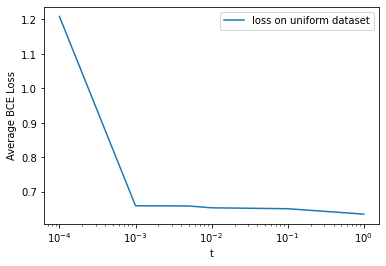

In [25]:
plt.plot(t_list, comp_losses, label='loss on uniform dataset')
plt.legend(loc=0)
plt.ylabel('Average BCE Loss')
plt.xlabel('t')
plt.xscale('log')
plt.show()

# Validation

## Load Datasets

In [ ]:
test_dataset_0 = np.load(data_dir+'test1D_default.npz')
test_dataset_1 = np.load(data_dir+'test_3D_known.npz')

In [ ]:
# Define labels for legends
label_0 = r'Default'

label_1 = r'Non-default'

pythia_text = r'\textsc{Pythia 8}' + '\n' + r'$e^+e^- \to Z \to $ dijets' +'\n'+ r"anti-$k_{\mathrm{T}}$, $R=0.8$"
def make_legend():
    ax = plt.gca()
    leg = ax.legend(frameon=False)
    leg.set_title(pythia_text, prop={'size':14})
    leg._legend_box.align = "left"
    plt.tight_layout()

## Get predictions

In [ ]:
# Load test datasets
X0_test = preprocess_data(test_dataset_0['jet'])
X1_test = preprocess_data(test_dataset_1['jet'])

In [ ]:
# Get predicted probabilities
preds_0 = dctr.predict(X0_test, batch_size=1000)
preds_1 = dctr.predict(X1_test, batch_size=1000)

## Get weights

In [ ]:
weights_0 = preds_0[:,0]/preds_0[:,1]
weights_1 = preds_1[:,0]/preds_1[:,1]

## Analyze weights

In [ ]:
print(max(weights_0))
print(max(1/weights_0))
print(max(weights_1))
print(max(1/weights_1))

In [ ]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_0, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r' $\rightarrow$ ' + label_0, fontsize=20)
plt.show()

In [ ]:
clip_val = 3
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_1, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r' $\rightarrow$ ' + label_1, fontsize=20)
plt.show()

# Validation Plots

In [ ]:
# Define default plot styles
plot_style_0 = {'histtype':'step', 'color':'black', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_1 = {'alpha':0.5, 'density':True}

## Multiplicity

In [ ]:
plt.figure(figsize=(6,5))
bins = np.linspace(0,40,21)
hist0 = plt.hist(test_dataset_0['multiplicity'], bins = bins, label = label_0, **plot_style_0)
hist1 = plt.hist(test_dataset_1['multiplicity'], bins = bins, label = label_1, **plot_style_1)
hist2 = plt.hist(test_dataset_1['multiplicity'], bins = bins, label = label_1 + ' wgt.', weights=weights_1, **plot_style_1)

plt.xlabel('Multiplicity')
plt.ylabel('Jets per bin (normalized)')
plt.xlim([0,40])
make_legend()
plt.show()

## Nsubjettiness

### tau21

In [ ]:
plt.figure(figsize=(6,5))
bins = np.linspace(0,1,31)
hist0 = plt.hist(test_dataset_0['tau21'], bins=bins, label=label_0, **plot_style_0)
hist1 = plt.hist(test_dataset_1['tau21'], bins=bins, label=label_1, **plot_style_1)
hist2 = plt.hist(test_dataset_1['tau21'], bins=bins, label=label_1 +' wgt.',  weights= weights_1, **plot_style_1)

plt.xlabel('tau21')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

### tau32

In [ ]:
plt.figure(figsize=(6,5))
bins = np.linspace(0,1,31)
hist0 = plt.hist(test_dataset_0['tau32'], bins=bins, label=label_0, **plot_style_0)
hist1 = plt.hist(test_dataset_1['tau32'], bins=bins, label=label_1, **plot_style_1)
hist2 = plt.hist(test_dataset_1['tau32'], bins=bins, label=label_1 +' wgt.',  weights= weights_1, **plot_style_1)

plt.xlabel('tau32')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

## ECF

### N=3, $\beta$=4

In [ ]:
plt.figure(figsize=(6,5))
bins = np.linspace(-15,5,31)
hist1 = plt.hist(np.log(test_dataset_0['ECF_N3_B4']), bins=bins, label=label_0, **plot_style_0)
hist2 = plt.hist(np.log(test_dataset_1['ECF_N3_B4']), bins=bins, label=label_1, **plot_style_1)
hist3 = plt.hist(np.log(test_dataset_1['ECF_N3_B4']), bins=bins, label=label_1 +' wgt.',  weights= weights_1, **plot_style_1)

plt.xlabel('log ECF(N=3, beta=4)')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

### N=4, $\beta$=4

In [ ]:
plt.figure(figsize=(6,5))
bins = np.linspace(-35,5,31)
hist1 = plt.hist(np.log(test_dataset_0['ECF_N4_B4']), bins=bins, label=label_0, **plot_style_0)
hist2 = plt.hist(np.log(test_dataset_1['ECF_N4_B4']), bins=bins, label=label_1, **plot_style_1)
hist3 = plt.hist(np.log(test_dataset_1['ECF_N4_B4']), bins=bins, label=label_1 +' wgt.',  weights= weights_1, **plot_style_1)

plt.xlabel('log ECF(N=4, beta=4)')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

## Kaons

In [ ]:
plt.figure(figsize=(6,5))
bins = np.linspace(0,10,11)
hist0 = plt.hist(test_dataset_0['number_of_kaons'], bins=bins, label=label_0, **plot_style_0)
hist1 = plt.hist(test_dataset_1['number_of_kaons'], bins=bins, label=label_1, **plot_style_1)
hist2 = plt.hist(test_dataset_1['number_of_kaons'], bins=bins, label=label_1 +' wgt.',  weights= weights_1, **plot_style_1)

plt.xlabel('Number of kaons')
plt.ylabel('Jets per bin (normalized)')
make_legend()
plt.show()

# Fitting

## Loss Curve Model

In [ ]:
class AddParams2Input(keras.layers.Layer):
    """ Custom layer for tuning with DCTR: 
    Arguments:
    - n_MC_params : (int) - the number of n_MC_params that are in X_dim
    - default_MC_params : (list of floats) - default values for each of the MC parameters
    - trainable_MC_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Usage: 
    Let X_dim be the input dimension of each particle to a PFN model, and n_MC_params be the number of MC parameters. 
    Defines a Layer that takes in an array of dimension 
    (batch_size, padded_multiplicity, X_dim - n_MC_params)
    This layer appends each particle by the default_MC_params and makes then trainable or non-trainable based on trainable_MC_params
    """
    
    def __init__(self, n_MC_params, default_MC_params, trainable_MC_params):
        super(AddParams2Input, self).__init__()
        # Definitions
        self.n_MC_params = n_MC_params
        self.MC_params = default_MC_params
        self.trainable_MC_params = trainable_MC_params

    
    def build(self, input_shape):
        # Convert input MC parameters to weights and make then trainable or non-trainable
        for i in range(self.n_MC_params):
            self.MC_params[i] = self.add_weight(name='MC_param_{}'.format(i), 
                                                shape=(1, 1),
                                                initializer=keras.initializers.Constant(self.MC_params[i]),
                                                trainable=self.trainable_MC_params[i])
            
        self.MC_params = keras.backend.tf.concat(self.MC_params, axis = -1)
        super(AddParams2Input, self).build(input_shape)
    
    def call(self, input):
        # Add MC params to each input particle (but not to the padded rows)
        concat_input_and_params = keras.backend.tf.where(keras.backend.abs(input[...,0])>0,
                                                         self.MC_params*keras.backend.ones_like(input[...,0:self.n_MC_params]),
                                                         keras.backend.zeros_like(input[...,0:self.n_MC_params]))
        return keras.backend.concatenate([input, concat_input_and_params], -1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]+self.n_MC_params)

In [ ]:
def get_DCTR_fit_model(DCTR_model, 
                       X_dim, 
                       n_MC_params, 
                       default_MC_params,
                       trainable_MC_params):
    """ 
    Get a DCTR model that trains on the input MC parameters
    
    Arguments:
    - DCTR_model : a PFN model that has been trained on a to continuously interpolate over the input MC dimensions
    - X_dim : (int) - the dimension of the input expected by DCTR_model
    - n_MC_params : (int) - the number of n_MC_params that are in X_dim
    - default_MC_params : (list of floats) - default values for each of the MC parameters
    - trainable_MC_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Returns:
    - DCTR_fit_model: a compiled model that gradient descends only on the trainable MC parameters
    """
    
    # Do sanity checks on inputs
    assert X_dim >=n_MC_params, "X_dim must be larger than n_MC_params. X_dim includes the dimensionality of the 4-vector + number of MC parameters"
    assert n_MC_params == len(default_MC_params), "Dimension mismatch between n_MC_params and number of default MC parameters given. len(default_MC_params) must equal n_MC_params"
    assert n_MC_params == len(trainable_MC_params), "Dimension mismatch between n_MC_params and trainable_MC_params. len(trainable_MC_params) must equal n_MC_params."
    assert np.any(trainable_MC_params), "All parameters are set to non-trainable."
    
    # Define input to DCTR_fit_model
    non_param_input = keras.layers.Input((None, X_dim - n_MC_params))

    # Construct layer that adds trainable and non-trainable parameters to the input
    add_params_layer = AddParams2Input(n_MC_params, default_MC_params, trainable_MC_params)
    time_dist     = keras.layers.TimeDistributed(add_params_layer, name='tdist')(non_param_input)     

    # Set all weights in DCTR_model to non-trainable
    for layer in DCTR_model.model.layers:
        layer.trainable = False
        
    # get the graph and the weights from the DCTR_model
    output = DCTR_model.model(inputs = time_dist)

    # Define full model
    DCTR_fit_model = fitmodel = keras.models.Model(inputs = non_param_input, outputs = output)
    
    optimizer = keras.optimizers.Adam(lr=1e-4)
    
    # Compile with loss function
    DCTR_fit_model.compile(optimizer=optimizer, loss='categorical_crossentropy')
    
    return DCTR_fit_model

In [ ]:
dctr_fit_model = get_DCTR_fit_model(dctr, 
                       X_dim =7, 
                       n_MC_params = 3, 
                       default_MC_params   = [0.1365, 0.68, 0.217], # default params for [alpha_s, aLund, StoUD]
                       trainable_MC_params = [True, True, True]) # Only train alpha_s

dctr_fit_model.summary()

In [ ]:
def set_MC_params(dctr_fit_model, MC_params):
    alphaS, aLund, StoUD = MC_params
    weights = [np.array([[alphaS]],   dtype=np.float32),
               np.array([[aLund]],    dtype=np.float32),
               np.array([[StoUD]], dtype=np.float32)]
    dctr_fit_model.layers[1].set_weights(weights)

In [ ]:
dctr_fit_model.layers[1].get_weights()

## Load Data

In [ ]:
default_dataset = np.load(data_dir + 'test1D_default.npz')
unknown_dataset = np.load(data_dir + 'test_3D_known.npz')

In [ ]:
X_default = preprocess_data(default_dataset['jet'][:,:,:4])
X_unknown = preprocess_data(unknown_dataset['jet'][:,:,:4])

Y_default = np.zeros_like(X_unknown[:,0,0])
Y_unknown = np.ones_like(X_unknown[:,0,0])

In [ ]:
X_fit = np.concatenate((X_default, X_unknown), axis = 0)

Y_fit = np.concatenate((Y_default, Y_unknown), axis = 0)
Y_fit = to_categorical(Y_fit, num_classes=2)

In [ ]:
X_fit, _, Y_fit, _ = data_split(X_fit, Y_fit, test=0, shuffle=True)

## Tune with Gradient Descent

In [ ]:
print_weights = keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               print("(alpha_s, aLund, probStoUD)=({:.4f}, {:.4f}, {:.4f})".format(*np.array(dctr_fit_model.layers[1].get_weights()).flatten())))
fit_vals = [[0.1365, 0.68, 0.217]]
append_weights = keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: 
                                               fit_vals.append(list(np.array(dctr_fit_model.layers[1].get_weights()).flatten())))

callbacks = [print_weights, append_weights]

In [ ]:
dctr_fit_model.fit(X_fit, Y_fit,
                   epochs=40, 
                   batch_size=10000,
                   callbacks = callbacks)

In [ ]:
fit_vals = np.array(fit_vals)

In [ ]:
plt.plot(fit_vals[:,0]/0.1200, marker='o')

plt.plot(fit_vals[:,1]/0.6000 , marker='o')

plt.plot(fit_vals[:,2]/0.1200, marker='o')

plt.xlabel("Epochs")
plt.ylabel(r'fit value/target')
plt.show()